# Load library

In [1]:
#Import lib
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from my_useful_functions import calculate_performance_statistical_parity,calculate_performance_equalized_odds,calculate_performance_equal_opportunity,calculate_performance_predictive_parity,calculate_performance_predictive_equality,calculate_performance_treatment_equality
from sklearn import preprocessing
from aif360.datasets.binary_label_dataset import BinaryLabelDataset
# DT
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
# NB
from sklearn.naive_bayes import GaussianNB
# MLP
from sklearn.neural_network import MLPClassifier
# kNN
from sklearn.neighbors import KNeighborsClassifier
# Adafair
from AdaFair import AdaFair 
# Agarwal
from exponentiated_gradient_reduction import ExponentiatedGradientReduction
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
# DIR
from disparate_impact_remover import DisparateImpactRemover
# LFR
from learning_fair_representations import LFR
# EOP
from eq_odds_postprocessing import EqOddsPostprocessing
# CEP
from calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from compute_abroca import *
import numpy as np
import sklearn.metrics as metrics 
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pip install 'aif360[LawSchoolGPA]'
2023-03-27 10:52:30.405688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 10:52:30.405704: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Dataset

## Credit approval

In [2]:
def load_credit_approval():
    df = pd.read_csv('data/credit-approval.data',sep=",")
    protected_attribute = 'Male'
    majority_group_name = "Female"
    minority_group_name = "Male"
    class_label = 'Approved'
    
    print("Length:",len(df))
    print("Number of attribute:",len(df.columns))
    #Remove missing value
    df = df[df['Male'] != '?']   
    #Label sex
    df['Male']=["Female" if v == "a" else "Male" for v in df['Male']]
    #Label class
    df['Approved']=[1 if v == "+" else 0 for v in df['Approved']]
    
    print("Length (cleaned):",len(df))
    print("Class imbalance: \n",df[class_label].value_counts())
    
    le = preprocessing.LabelEncoder()
    for i in df.columns:
        if df[i].dtypes == 'object':
            df[i] = le.fit_transform(df[i])
    #Splitting data into train and test
    length = len(df.columns)
    X = df.iloc[:,:length-1]
    y = df[class_label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
    
    #Get index    
    feature = X.keys().tolist()    
    sa_index = feature.index(protected_attribute)
    p_Group = 0 
    
    return X_train, X_test, y_train, y_test,sa_index, p_Group, protected_attribute,majority_group_name,minority_group_name

# Run experiment

In [3]:
def run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm='', postprocessing_algorithm=''):    
    datasetTrain = BinaryLabelDataset(df=pd.concat([X_train, y_train.to_frame()], axis=1), label_names=[y_train.name], protected_attribute_names=[protected_attribute])
    datasetTest = BinaryLabelDataset(df=pd.concat([X_test, y_test.to_frame()], axis=1), label_names=[y_test.name], protected_attribute_names=[protected_attribute])
    
    # preprocessing
    if preprocessing_algorithm != '': 
        if preprocessing_algorithm == 'DIR':
            pre_model = DisparateImpactRemover(sensitive_attribute=protected_attribute)
        elif preprocessing_algorithm == 'LFR':
            privileged_groups = [{protected_attribute: 1.0}]
            unprivileged_groups = [{protected_attribute: 0.0}]
            pre_model = LFR(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
        dataset_train_transf = pre_model.fit_transform(datasetTrain)
        dataset_test_transf = pre_model.transform(datasetTest)

        X_train_transf = dataset_train_transf.features
        y_train_transf = dataset_train_transf.labels.ravel()
        X_test_transf = dataset_test_transf.features
        y_test_transf= dataset_test_transf.labels.ravel()

        X_train_transf = pd.DataFrame(X_train_transf, columns = X_train.columns)
        y_train_transf = pd.Series(y_train_transf, name = y_train.name).astype(int)
        X_test_transf = pd.DataFrame(X_test_transf, columns = X_train.columns)
        y_test_transf = pd.Series(y_test_transf, name = y_train.name).astype(int)
    
    # inprocessing
    if algorithm == 'DT':
        model = tree.DecisionTreeClassifier(random_state=0)  
    elif algorithm == 'NB': 
        model = GaussianNB()
    elif algorithm == 'MLP':
        model = MLPClassifier(random_state=1, max_iter=300)
    elif algorithm == 'kNN':
        model = KNeighborsClassifier(n_neighbors=5)
    elif algorithm == 'Ada':
        model = AdaFair(n_estimators=50, saIndex=sa_index, saValue=p_Group, CSB="CSB2", c=1, use_validation=False)
    elif algorithm == 'Agar':
        clf =  NB = GaussianNB()
        model = ExponentiatedGradientReduction(prot_attr=protected_attribute,estimator=clf, constraints = "EqualizedOdds")
    
    if preprocessing_algorithm != '':
        model.fit(X_train_transf, y_train_transf)
        y_predicts = model.predict(X_test_transf)
    else:
        model.fit(X_train,y_train)
        y_predicts = model.predict(X_test)

    # postprocessing
    if postprocessing_algorithm != '':
        privileged_groups = [{protected_attribute: 1.0}]
        unprivileged_groups = [{protected_attribute: 0.0}]
        if postprocessing_algorithm == 'EOP':
            post_model = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, seed=42)
        if postprocessing_algorithm == 'CEP':
            post_model = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, seed=42)
        
        y_test_predicts = model.predict(X_test)
        y_train_predicts = model.predict(X_train)

        X_train_predicts = X_train.copy()
        X_test_predicts = X_test.copy()

        X_train_predicts[y_train.name] = y_train_predicts
        X_test_predicts[y_train.name] = y_test_predicts
    
        dataset_train_true = BinaryLabelDataset(df=pd.concat([X_train, y_train.to_frame()], axis=1), label_names=[y_train.name], protected_attribute_names=[protected_attribute])
        dataset_train_predicts = BinaryLabelDataset(df=X_train_predicts, label_names=[y_train.name], protected_attribute_names=[protected_attribute])
        dataset_test_predicts = BinaryLabelDataset(df=X_test_predicts, label_names=[y_test.name], protected_attribute_names=[protected_attribute])

        post_model.fit_predict(dataset_true=dataset_train_true, dataset_pred=dataset_train_predicts)
        dataset_predicts_transf = post_model.predict(dataset_test_predicts)
        data_predicts = dataset_predicts_transf.convert_to_dataframe()[0]
        y_predicts = data_predicts[y_test.name].astype(int)

    print("Statistical parity:")
    print(calculate_performance_statistical_parity(X_test.values, y_test.values, y_predicts, sa_index, p_Group))
         
    print("Equal opportunity")
    print(calculate_performance_equal_opportunity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Equalized odds")
    print(calculate_performance_equalized_odds(X_test.values, y_test.values, y_predicts, sa_index, p_Group))
         
    print("Predictive parity")
    print(calculate_performance_predictive_parity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Predictive equality")
    print(calculate_performance_predictive_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Treatment equality")
    print(calculate_performance_treatment_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    filename = '{}.{}.abroca.pdf'.format(dataset, preprocessing_algorithm+algorithm)
    #make predictions
    if postprocessing_algorithm == '':
        if preprocessing_algorithm:
            X_test['pred_proba'] = model.predict_proba(X_test_transf)[:,1:2]
        else:
            X_test['pred_proba'] = model.predict_proba(X_test)[:,1:2]
        X_test['true_label'] = y_test
        df_test = X_test

        #Compute Abroca
        slice = compute_abroca(df_test, pred_col = 'pred_proba' , label_col = 'true_label', protected_attr_col = protected_attribute,
                            majority_protected_attr_val = 1, n_grid = 10000,
                            plot_slices = True, majority_group_name=majority_group_name ,minority_group_name=minority_group_name,file_name = filename)
        print("ABROCA:",slice)
        plt.clf() 
    plt.clf() 
    

In [4]:
#Main function
def run_eval(dataset, algorithm, preprocessing_algorithm='', postprocessing_algorithm=''):
    if dataset == 'credit-approval':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_approval()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                        
    if dataset == 'credit-card':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_card()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                        
    if dataset == 'german-credit':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_german_credit()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                            
    if dataset == 'PAKDD':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_PAKDD2010()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                
    if dataset == 'credit-scoring':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_scoring()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                        
    if dataset == 'application':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_application()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                       

## Credit-approval

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.7646198830409356, 'accuracy': 0.7696078431372549, 'f1-score': 0.7344632768361581, 'fairness': 0.08400664084117321}
Equal opportunity
{'balanced_accuracy': 0.7646198830409356, 'accuracy': 0.7696078431372549, 'f1-score': 0.7344632768361581, 'fairness': 0.09615384615384615, 'TPR_protected': 0.6538461538461539, 'TPR_non_protected': 0.75, 'TNR_protected': 0.8205128205128205, 'TNR_non_protected': 0.8}
Equalized odds
{'balanced_accuracy': 0.7646198830409356, 'accuracy': 0.7696078431372549, 'f1-score': 0.7344632768361581, 'fairness': 0.11666666666666659, 'TPR_protected': 0.6538461538461539, 'TPR_non_protected': 0.75, 'TNR_protected': 0.8205128205128205, 'TNR_non_protected': 0.8}
Predictive parity
{'balanced_accuracy': 0.7646198830409356, 'accuracy': 0.7696078431372549, 'f1-score': 0.7344632768361581, 'fairness': 0.05357142857142

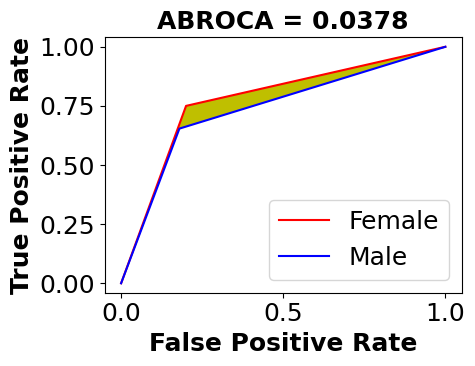

ABROCA: 0.037820514613555505


<Figure size 640x480 with 0 Axes>

In [5]:
run_eval(dataset='credit-approval', algorithm='DT')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.7628654970760234, 'accuracy': 0.7794117647058824, 'f1-score': 0.7133757961783439, 'fairness': 0.05301604869950194}
Equal opportunity
{'balanced_accuracy': 0.7628654970760234, 'accuracy': 0.7794117647058824, 'f1-score': 0.7133757961783439, 'fairness': 0.06370192307692313, 'TPR_protected': 0.5769230769230769, 'TPR_non_protected': 0.640625, 'TNR_protected': 0.8974358974358975, 'TNR_non_protected': 0.9066666666666666}
Equalized odds
{'balanced_accuracy': 0.7628654970760234, 'accuracy': 0.7794117647058824, 'f1-score': 0.7133757961783439, 'fairness': 0.07293269230769228, 'TPR_protected': 0.5769230769230769, 'TPR_non_protected': 0.640625, 'TNR_protected': 0.8974358974358975, 'TNR_non_protected': 0.9066666666666666}
Predictive parity
{'balanced_accuracy': 0.7628654970760234, 'accuracy': 0.7794117647058824, 'f1-score': 0.71337579

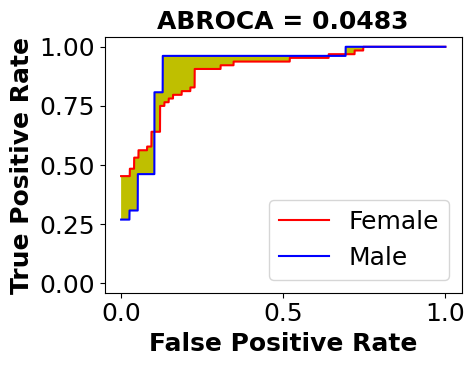

ABROCA: 0.048257820578755085


<Figure size 640x480 with 0 Axes>

In [6]:
run_eval(dataset='credit-approval', algorithm='NB')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.7038011695906433, 'accuracy': 0.7107843137254902, 'f1-score': 0.6628571428571428, 'fairness': 0.09219701162147204}
Equal opportunity
{'balanced_accuracy': 0.7038011695906433, 'accuracy': 0.7107843137254902, 'f1-score': 0.6628571428571428, 'fairness': 0.09495192307692313, 'TPR_protected': 0.5769230769230769, 'TPR_non_protected': 0.671875, 'TNR_protected': 0.7948717948717948, 'TNR_non_protected': 0.7466666666666667}
Equalized odds
{'balanced_accuracy': 0.7038011695906433, 'accuracy': 0.7107843137254902, 'f1-score': 0.6628571428571428, 'fairness': 0.14315705128205125, 'TPR_protected': 0.5769230769230769, 'TPR_non_protected': 0.671875, 'TNR_protected': 0.7948717948717948, 'TNR_non_protected': 0.7466666666666667}
Predictive parity
{'balanced_accuracy': 0.7038011695906433, 'accuracy': 0.7107843137254902, 'f1-score': 0.66285714

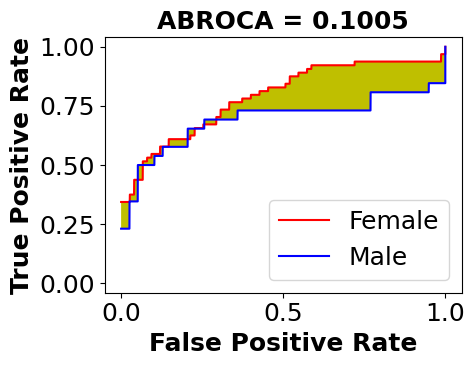

ABROCA: 0.1004862824417215


<Figure size 640x480 with 0 Axes>

In [7]:
run_eval(dataset='credit-approval', algorithm='MLP')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6494152046783626, 'accuracy': 0.6617647058823529, 'f1-score': 0.5868263473053892, 'fairness': -0.0105146651909242}
Equal opportunity
{'balanced_accuracy': 0.6494152046783626, 'accuracy': 0.6617647058823529, 'f1-score': 0.5868263473053892, 'fairness': 0.008413461538461564, 'TPR_protected': 0.5384615384615384, 'TPR_non_protected': 0.546875, 'TNR_protected': 0.717948717948718, 'TNR_non_protected': 0.7733333333333333}
Equalized odds
{'balanced_accuracy': 0.6494152046783626, 'accuracy': 0.6617647058823529, 'f1-score': 0.5868263473053892, 'fairness': 0.06379807692307693, 'TPR_protected': 0.5384615384615384, 'TPR_non_protected': 0.546875, 'TNR_protected': 0.717948717948718, 'TNR_non_protected': 0.7733333333333333}
Predictive parity
{'balanced_accuracy': 0.6494152046783626, 'accuracy': 0.6617647058823529, 'f1-score': 0.586826347

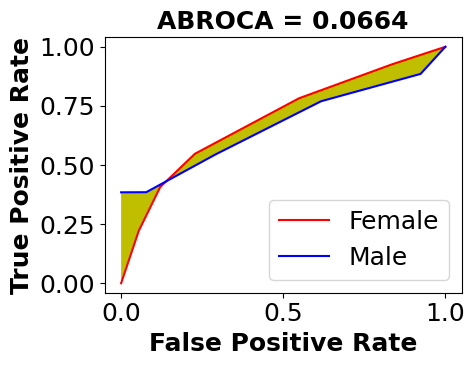

ABROCA: 0.0664343476038413


<Figure size 640x480 with 0 Axes>

In [8]:
run_eval(dataset='credit-approval', algorithm='kNN')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.8538011695906433, 'accuracy': 0.8431372549019608, 'f1-score': 0.8415841584158414, 'fairness': 0.06065301604869955}
Equal opportunity
{'balanced_accuracy': 0.8538011695906433, 'accuracy': 0.8431372549019608, 'f1-score': 0.8415841584158414, 'fairness': 0.024038461538461564, 'TPR_protected': 0.9615384615384616, 'TPR_non_protected': 0.9375, 'TNR_protected': 0.7948717948717948, 'TNR_non_protected': 0.7466666666666667}
Equalized odds
{'balanced_accuracy': 0.8538011695906433, 'accuracy': 0.8431372549019608, 'f1-score': 0.8415841584158414, 'fairness': 0.07224358974358969, 'TPR_protected': 0.9615384615384616, 'TPR_non_protected': 0.9375, 'TNR_protected': 0.7948717948717948, 'TNR_non_protected': 0.7466666666666667}
Predictive parity
{'balanced_accuracy': 0.8538011695906433, 'accuracy': 0.8431372549019608, 'f1-score': 0.84158415841

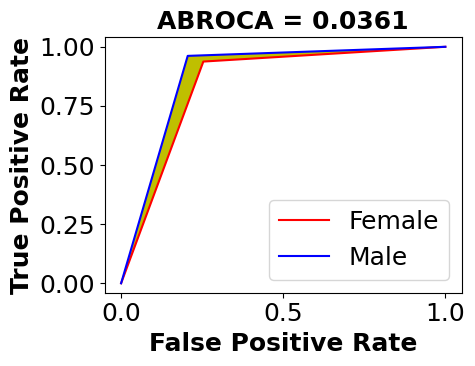

ABROCA: 0.03612179438188301


<Figure size 640x480 with 0 Axes>

In [9]:
run_eval(dataset='credit-approval', algorithm='Ada')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.7771929824561403, 'accuracy': 0.7941176470588235, 'f1-score': 0.7307692307692307, 'fairness': 0.023242944106253438}
Equal opportunity
{'balanced_accuracy': 0.7771929824561403, 'accuracy': 0.7941176470588235, 'f1-score': 0.7307692307692307, 'fairness': 0.02524038461538458, 'TPR_protected': 0.6153846153846154, 'TPR_non_protected': 0.640625, 'TNR_protected': 0.8974358974358975, 'TNR_non_protected': 0.9333333333333333}
Equalized odds
{'balanced_accuracy': 0.7771929824561403, 'accuracy': 0.7941176470588235, 'f1-score': 0.7307692307692307, 'fairness': 0.06113782051282046, 'TPR_protected': 0.6153846153846154, 'TPR_non_protected': 0.640625, 'TNR_protected': 0.8974358974358975, 'TNR_non_protected': 0.9333333333333333}
Predictive parity
{'balanced_accuracy': 0.7771929824561403, 'accuracy': 0.7941176470588235, 'f1-score': 0.7307692

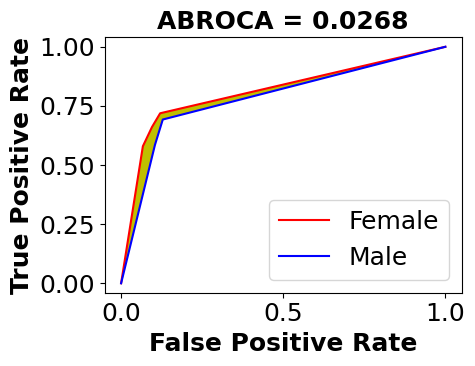

ABROCA: 0.02678192210182472


<Figure size 640x480 with 0 Axes>

In [10]:
run_eval(dataset='credit-approval', algorithm='Agar')

In [11]:
run_eval(dataset='credit-approval', algorithm='DT', preprocessing_algorithm='DIR')              

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5421052631578946, 'accuracy': 0.5196078431372549, 'f1-score': 0.5739130434782609, 'fairness': 0.013724405091311564}
Equal opportunity
{'balanced_accuracy': 0.5421052631578946, 'accuracy': 0.5196078431372549, 'f1-score': 0.5739130434782609, 'fairness': 0.11177884615384615, 'TPR_protected': 0.6538461538461539, 'TPR_non_protected': 0.765625, 'TNR_protected': 0.3076923076923077, 'TNR_non_protected': 0.37333333333333335}
Equalized odds
{'balanced_accuracy': 0.5421052631578946, 'accuracy': 0.5196078431372549, 'f1-score': 0.5739130434782609, 'fairness': 0.1774198717948718, 'TPR_protected': 0.6538461538461539, 'TPR_non_protected': 0.765625, 'TNR_protected': 0.3076923076923077, 'TNR_non_protected': 0.37333333333333335}
Predictive parity
{'balanced_accuracy': 0.5421052631578946, 'accuracy': 0.5196078431372549, 'f1-score': 0.573913

In [12]:
run_eval(dataset='credit-approval', algorithm='NB', preprocessing_algorithm='DIR')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.8263157894736842, 'accuracy': 0.8333333333333334, 'f1-score': 0.8023255813953488, 'fairness': -0.04228002213613724}
Equal opportunity
{'balanced_accuracy': 0.8263157894736842, 'accuracy': 0.8333333333333334, 'f1-score': 0.8023255813953488, 'fairness': 0.16586538461538458, 'TPR_protected': 0.8846153846153846, 'TPR_non_protected': 0.71875, 'TNR_protected': 0.8717948717948718, 'TNR_non_protected': 0.8933333333333333}
Equalized odds
{'balanced_accuracy': 0.8263157894736842, 'accuracy': 0.8333333333333334, 'f1-score': 0.8023255813953488, 'fairness': 0.1874038461538461, 'TPR_protected': 0.8846153846153846, 'TPR_non_protected': 0.71875, 'TNR_protected': 0.8717948717948718, 'TNR_non_protected': 0.8933333333333333}
Predictive parity
{'balanced_accuracy': 0.8263157894736842, 'accuracy': 0.8333333333333334, 'f1-score': 0.8023255813

In [13]:
run_eval(dataset='credit-approval', algorithm='MLP', preprocessing_algorithm='DIR')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.7359649122807017, 'accuracy': 0.7401960784313726, 'f1-score': 0.7039106145251396, 'fairness': 0.008079690094078551}
Equal opportunity
{'balanced_accuracy': 0.7359649122807017, 'accuracy': 0.7401960784313726, 'f1-score': 0.7039106145251396, 'fairness': 0.06490384615384615, 'TPR_protected': 0.6538461538461539, 'TPR_non_protected': 0.71875, 'TNR_protected': 0.717948717948718, 'TNR_non_protected': 0.8}
Equalized odds
{'balanced_accuracy': 0.7359649122807017, 'accuracy': 0.7401960784313726, 'f1-score': 0.7039106145251396, 'fairness': 0.14695512820512824, 'TPR_protected': 0.6538461538461539, 'TPR_non_protected': 0.71875, 'TNR_protected': 0.717948717948718, 'TNR_non_protected': 0.8}
Predictive parity
{'balanced_accuracy': 0.7359649122807017, 'accuracy': 0.7401960784313726, 'f1-score': 0.7039106145251396, 'fairness': 0.146955503

In [14]:
run_eval(dataset='credit-approval', algorithm='kNN', preprocessing_algorithm='DIR')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6570175438596491, 'accuracy': 0.6715686274509803, 'f1-score': 0.588957055214724, 'fairness': 0.005866076369673456}
Equal opportunity
{'balanced_accuracy': 0.6570175438596491, 'accuracy': 0.6715686274509803, 'f1-score': 0.588957055214724, 'fairness': 0.046875, 'TPR_protected': 0.5, 'TPR_non_protected': 0.546875, 'TNR_protected': 0.7435897435897436, 'TNR_non_protected': 0.8}
Equalized odds
{'balanced_accuracy': 0.6570175438596491, 'accuracy': 0.6715686274509803, 'f1-score': 0.588957055214724, 'fairness': 0.10328525641025643, 'TPR_protected': 0.5, 'TPR_non_protected': 0.546875, 'TNR_protected': 0.7435897435897436, 'TNR_non_protected': 0.8}
Predictive parity
{'balanced_accuracy': 0.6570175438596491, 'accuracy': 0.6715686274509803, 'f1-score': 0.588957055214724, 'fairness': 0.13478260869565217, 'TPR_protected': 0.5, 'TPR_non_

In [16]:
run_eval(dataset='credit-approval', algorithm='DT', preprocessing_algorithm='LFR')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5523391812865497, 'accuracy': 0.6029411764705882, 'f1-score': 0.21359223300970873, 'fairness': -0.041947980077476486}
Equal opportunity
{'balanced_accuracy': 0.5523391812865497, 'accuracy': 0.6029411764705882, 'f1-score': 0.21359223300970873, 'fairness': 0.15264423076923078, 'TPR_protected': 0.23076923076923078, 'TPR_non_protected': 0.078125, 'TNR_protected': 1.0, 'TNR_non_protected': 0.9733333333333334}
Equalized odds
{'balanced_accuracy': 0.5523391812865497, 'accuracy': 0.6029411764705882, 'f1-score': 0.21359223300970873, 'fairness': 0.1793108974358974, 'TPR_protected': 0.23076923076923078, 'TPR_non_protected': 0.078125, 'TNR_protected': 1.0, 'TNR_non_protected': 0.9733333333333334}
Predictive parity
{'balanced_accuracy': 0.5523391812865497, 'accuracy': 0.6029411764705882, 'f1-score': 0.21359223300970873, 'fairness': 0

In [18]:
run_eval(dataset='credit-approval', algorithm='NB', preprocessing_algorithm='LFR')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5233918128654971, 'accuracy': 0.5784313725490197, 'f1-score': 0.10416666666666666, 'fairness': -0.024571112340896515}
Equal opportunity
{'balanced_accuracy': 0.5233918128654971, 'accuracy': 0.5784313725490197, 'f1-score': 0.10416666666666666, 'fairness': 0.08413461538461539, 'TPR_protected': 0.11538461538461539, 'TPR_non_protected': 0.03125, 'TNR_protected': 1.0, 'TNR_non_protected': 0.9866666666666667}
Equalized odds
{'balanced_accuracy': 0.5233918128654971, 'accuracy': 0.5784313725490197, 'f1-score': 0.10416666666666666, 'fairness': 0.0974679487179487, 'TPR_protected': 0.11538461538461539, 'TPR_non_protected': 0.03125, 'TNR_protected': 1.0, 'TNR_non_protected': 0.9866666666666667}
Predictive parity
{'balanced_accuracy': 0.5233918128654971, 'accuracy': 0.5784313725490197, 'f1-score': 0.10416666666666666, 'fairness': 0.3

In [19]:
run_eval(dataset='credit-approval', algorithm='MLP', preprocessing_algorithm='LFR')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5388888888888889, 'accuracy': 0.5931372549019608, 'f1-score': 0.1443298969072165, 'fairness': -0.0399557277255119}
Equal opportunity
{'balanced_accuracy': 0.5388888888888889, 'accuracy': 0.5931372549019608, 'f1-score': 0.1443298969072165, 'fairness': 0.10697115384615385, 'TPR_protected': 0.15384615384615385, 'TPR_non_protected': 0.046875, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5388888888888889, 'accuracy': 0.5931372549019608, 'f1-score': 0.1443298969072165, 'fairness': 0.10697115384615385, 'TPR_protected': 0.15384615384615385, 'TPR_non_protected': 0.046875, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5388888888888889, 'accuracy': 0.5931372549019608, 'f1-score': 0.1443298969072165, 'fairness': 0.0, 'TPR_protected': 0.153846153846

In [20]:
run_eval(dataset='credit-approval', algorithm='kNN', preprocessing_algorithm='LFR')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.5588235294117647, 'f1-score': 0.0, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.5588235294117647, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.5588235294117647, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.5588235294117647, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.5588235294117647, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_p

In [21]:
run_eval(dataset='credit-approval', algorithm='DT', postprocessing_algorithm='EOP')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.7646198830409356, 'accuracy': 0.7696078431372549, 'f1-score': 0.7344632768361581, 'fairness': 0.08400664084117321}
Equal opportunity
{'balanced_accuracy': 0.7646198830409356, 'accuracy': 0.7696078431372549, 'f1-score': 0.7344632768361581, 'fairness': 0.09615384615384615, 'TPR_protected': 0.6538461538461539, 'TPR_non_protected': 0.75, 'TNR_protected': 0.8205128205128205, 'TNR_non_protected': 0.8}
Equalized odds
{'balanced_accuracy': 0.7646198830409356, 'accuracy': 0.7696078431372549, 'f1-score': 0.7344632768361581, 'fairness': 0.11666666666666659, 'TPR_protected': 0.6538461538461539, 'TPR_non_protected': 0.75, 'TNR_protected': 0.8205128205128205, 'TNR_non_protected': 0.8}
Predictive parity
{'balanced_accuracy': 0.7646198830409356, 'accuracy': 0.7696078431372549, 'f1-score': 0.7344632768361581, 'fairness': 0.05357142857142

In [22]:
run_eval(dataset='credit-approval', algorithm='NB', postprocessing_algorithm='EOP')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.7628654970760234, 'accuracy': 0.7794117647058824, 'f1-score': 0.7133757961783439, 'fairness': 0.05301604869950194}
Equal opportunity
{'balanced_accuracy': 0.7628654970760234, 'accuracy': 0.7794117647058824, 'f1-score': 0.7133757961783439, 'fairness': 0.06370192307692313, 'TPR_protected': 0.5769230769230769, 'TPR_non_protected': 0.640625, 'TNR_protected': 0.8974358974358975, 'TNR_non_protected': 0.9066666666666666}
Equalized odds
{'balanced_accuracy': 0.7628654970760234, 'accuracy': 0.7794117647058824, 'f1-score': 0.7133757961783439, 'fairness': 0.07293269230769228, 'TPR_protected': 0.5769230769230769, 'TPR_non_protected': 0.640625, 'TNR_protected': 0.8974358974358975, 'TNR_non_protected': 0.9066666666666666}
Predictive parity
{'balanced_accuracy': 0.7628654970760234, 'accuracy': 0.7794117647058824, 'f1-score': 0.71337579

In [23]:
run_eval(dataset='credit-approval', algorithm='MLP', postprocessing_algorithm='EOP')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6938596491228071, 'accuracy': 0.7009803921568627, 'f1-score': 0.6514285714285714, 'fairness': 0.13735473159933592}
Equal opportunity
{'balanced_accuracy': 0.6938596491228071, 'accuracy': 0.7009803921568627, 'f1-score': 0.6514285714285714, 'fairness': 0.13341346153846156, 'TPR_protected': 0.5384615384615384, 'TPR_non_protected': 0.671875, 'TNR_protected': 0.8205128205128205, 'TNR_non_protected': 0.72}
Equalized odds
{'balanced_accuracy': 0.6938596491228071, 'accuracy': 0.7009803921568627, 'f1-score': 0.6514285714285714, 'fairness': 0.23392628205128208, 'TPR_protected': 0.5384615384615384, 'TPR_non_protected': 0.671875, 'TNR_protected': 0.8205128205128205, 'TNR_non_protected': 0.72}
Predictive parity
{'balanced_accuracy': 0.6938596491228071, 'accuracy': 0.7009803921568627, 'f1-score': 0.6514285714285714, 'fairness': 0.0052

In [24]:
run_eval(dataset='credit-approval', algorithm='kNN', postprocessing_algorithm='EOP')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6283625730994151, 'accuracy': 0.6421568627450981, 'f1-score': 0.5575757575757575, 'fairness': 0.02025456557830657}
Equal opportunity
{'balanced_accuracy': 0.6283625730994151, 'accuracy': 0.6421568627450981, 'f1-score': 0.5575757575757575, 'fairness': 0.12379807692307693, 'TPR_protected': 0.4230769230769231, 'TPR_non_protected': 0.546875, 'TNR_protected': 0.6923076923076923, 'TNR_non_protected': 0.7733333333333333}
Equalized odds
{'balanced_accuracy': 0.6283625730994151, 'accuracy': 0.6421568627450981, 'f1-score': 0.5575757575757575, 'fairness': 0.20482371794871795, 'TPR_protected': 0.4230769230769231, 'TPR_non_protected': 0.546875, 'TNR_protected': 0.6923076923076923, 'TNR_non_protected': 0.7733333333333333}
Predictive parity
{'balanced_accuracy': 0.6283625730994151, 'accuracy': 0.6421568627450981, 'f1-score': 0.55757575

In [25]:
run_eval(dataset='credit-approval', algorithm='DT', postprocessing_algorithm='CEP')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.7646198830409356, 'accuracy': 0.7696078431372549, 'f1-score': 0.7344632768361581, 'fairness': 0.08400664084117321}
Equal opportunity
{'balanced_accuracy': 0.7646198830409356, 'accuracy': 0.7696078431372549, 'f1-score': 0.7344632768361581, 'fairness': 0.09615384615384615, 'TPR_protected': 0.6538461538461539, 'TPR_non_protected': 0.75, 'TNR_protected': 0.8205128205128205, 'TNR_non_protected': 0.8}
Equalized odds
{'balanced_accuracy': 0.7646198830409356, 'accuracy': 0.7696078431372549, 'f1-score': 0.7344632768361581, 'fairness': 0.11666666666666659, 'TPR_protected': 0.6538461538461539, 'TPR_non_protected': 0.75, 'TNR_protected': 0.8205128205128205, 'TNR_non_protected': 0.8}
Predictive parity
{'balanced_accuracy': 0.7646198830409356, 'accuracy': 0.7696078431372549, 'f1-score': 0.7344632768361581, 'fairness': 0.05357142857142

In [26]:
run_eval(dataset='credit-approval', algorithm='NB', postprocessing_algorithm='CEP')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.7573099415204678, 'accuracy': 0.7745098039215687, 'f1-score': 0.7051282051282051, 'fairness': 0.04582180409518538}
Equal opportunity
{'balanced_accuracy': 0.7573099415204678, 'accuracy': 0.7745098039215687, 'f1-score': 0.7051282051282051, 'fairness': 0.04807692307692313, 'TPR_protected': 0.5769230769230769, 'TPR_non_protected': 0.625, 'TNR_protected': 0.8974358974358975, 'TNR_non_protected': 0.9066666666666666}
Equalized odds
{'balanced_accuracy': 0.7573099415204678, 'accuracy': 0.7745098039215687, 'f1-score': 0.7051282051282051, 'fairness': 0.05730769230769228, 'TPR_protected': 0.5769230769230769, 'TPR_non_protected': 0.625, 'TNR_protected': 0.8974358974358975, 'TNR_non_protected': 0.9066666666666666}
Predictive parity
{'balanced_accuracy': 0.7573099415204678, 'accuracy': 0.7745098039215687, 'f1-score': 0.70512820512820

In [27]:
run_eval(dataset='credit-approval', algorithm='MLP', postprocessing_algorithm='CEP')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6982456140350877, 'accuracy': 0.7058823529411765, 'f1-score': 0.6551724137931035, 'fairness': 0.10758162700608742}
Equal opportunity
{'balanced_accuracy': 0.6982456140350877, 'accuracy': 0.7058823529411765, 'f1-score': 0.6551724137931035, 'fairness': 0.13341346153846156, 'TPR_protected': 0.5384615384615384, 'TPR_non_protected': 0.671875, 'TNR_protected': 0.7948717948717948, 'TNR_non_protected': 0.7466666666666667}
Equalized odds
{'balanced_accuracy': 0.6982456140350877, 'accuracy': 0.7058823529411765, 'f1-score': 0.6551724137931035, 'fairness': 0.1816185897435897, 'TPR_protected': 0.5384615384615384, 'TPR_non_protected': 0.671875, 'TNR_protected': 0.7948717948717948, 'TNR_non_protected': 0.7466666666666667}
Predictive parity
{'balanced_accuracy': 0.6982456140350877, 'accuracy': 0.7058823529411765, 'f1-score': 0.655172413

In [28]:
run_eval(dataset='credit-approval', algorithm='kNN', postprocessing_algorithm='CEP')

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6304093567251462, 'accuracy': 0.6470588235294118, 'f1-score': 0.5499999999999999, 'fairness': 0.0971776425013835}
Equal opportunity
{'balanced_accuracy': 0.6304093567251462, 'accuracy': 0.6470588235294118, 'f1-score': 0.5499999999999999, 'fairness': 0.20072115384615385, 'TPR_protected': 0.34615384615384615, 'TPR_non_protected': 0.546875, 'TNR_protected': 0.7692307692307693, 'TNR_non_protected': 0.7733333333333333}
Equalized odds
{'balanced_accuracy': 0.6304093567251462, 'accuracy': 0.6470588235294118, 'f1-score': 0.5499999999999999, 'fairness': 0.2048237179487179, 'TPR_protected': 0.34615384615384615, 'TPR_non_protected': 0.546875, 'TNR_protected': 0.7692307692307693, 'TNR_non_protected': 0.7733333333333333}
Predictive parity
{'balanced_accuracy': 0.6304093567251462, 'accuracy': 0.6470588235294118, 'f1-score': 0.54999999